In [1]:
import math
import random
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.distributions import Normal
from torch.distributions import MultivariateNormal

import gym
from gym import spaces
import pandas as pd
import sys

import time

import numpy as np
tanh=np.tanh
import matplotlib.pyplot as plt
import math
pow=math.pow
exp=np.exp

from IPython.display import clear_output
import matplotlib.pyplot as plt
import matplotlib.animation as animation
from matplotlib import style
%matplotlib inline

from math import exp
import numpy as np
from scipy.integrate import odeint
import matplotlib.pyplot as plt


In [2]:
use_cuda = torch.cuda.is_available()
device   = torch.device("cuda" if use_cuda else "cpu")

In [3]:
from math import exp
import numpy as np
from scipy.integrate import odeint
import matplotlib.pyplot as plt

global dt
dt = 0.05

def CSTR(action, ti, x0):
    Fa0 = action
    def model(y,ti):
        x1 = y[0]           # Propylene oxide
        x2 = y[1]           # water with H2SO4
        x3 = y[2]           # Propylene glycol
        x4 = y[3]           # Methanol
        x5 = y[4]           # Temperature
        parameters = [1000, 75, 16000,60, 100, 1000 ]
        Fb0, T0, UA, Ta1, Fm0, mc = parameters
        V = (1/7.484)*500
        k = 16.96e12*math.exp(-32400/1.987/(y[4]+460))
        # ra = -k*Ca
        # rb = -k*Ca
        # rc = k*Ca
        Nm = y[3]*V
        Na = y[0]*V
        Nb = y[1]*V
        Nc = y[2]*V

        ThetaCp = 35 + Fb0/Fa0[0]*18 + Fm0/Fa0[0]*19.5
        v0 = Fa0[0]/0.923 + Fb0/3.45 + Fm0/1.54
        Ta2 = y[4] - (y[4]-Ta1)*exp(-UA/(18*mc))
        Ca0 = Fa0[0]/v0
        Cb0 = Fb0/v0
        Cm0 = Fm0/v0
        Q = mc*18*(Ta1-Ta2)
        tau = V/v0
        NCp = Na*35 + Nb*18 + Nc*46 + Nm*19.5

        dx1_dt = 1/tau*(Ca0 - x1) -k*x1
        dx2_dt = 1/tau*(Cb0 - x2) -k*x1
        dx3_dt = 1/tau*(0-x3) +  k*x1
        dx4_dt = 1/tau*(Cm0-x4)
        dx5_dt = (Q-Fa0[0]*ThetaCp*(x5-T0)+(-36000)*(-k*x1)*V)/NCp

        return np.array([dx1_dt, dx2_dt, dx3_dt, dx4_dt, dx5_dt])
    t = np.linspace(ti, ti+dt, 100)
    y = odeint(model, x0, t)
    All = y[-1]
    A = y[99, 0]
    B = y[99, 1]
    C = y[99, 2]
    D = y[99, 3]
    E = y[99, 4]
    
    rewards = -np.abs((All[2]-0.143))
    return All, rewards

# def get_state(action, t, x):
#     w = []
#     w.append(action)
#     p = CSTR(w, t, x)
#     conc = p[2]
#     reward = -np.abs((p[2]-0.143))
#     return p, reward

In [4]:
class ActorNet(nn.Module):
    def __init__(self):
        super(ActorNet, self).__init__()
        self.fc1 = nn.Linear(5, 10)
        self.mu_head = nn.Linear(10, 1)
        self.sigma_head = nn.Linear(10, 1)


    def forward(self, x):
        x1 = torch.sigmoid(self.fc1(x))
        mu = 160*(abs(self.mu_head(x1)))
#         sigma = (torch.exp((torch.tanh(self.sigma_head(x1)))))
#         mu = 80*(abs(self.mu_head(x2)))
#         # sigma = torch.exp((F.tanh(self.sigma_head(x1))))
        sigma = 2*(abs(self.sigma_head(x1)))
        return Normal(mu, sigma)

class CriticNet(nn.Module):

    def __init__(self):
        super(CriticNet, self).__init__()
        self.fc = nn.Linear(5, 10)
        self.v_head = nn.Linear(10, 1)

    def forward(self, x):
        x = F.relu(self.fc(x))
        state_value = self.v_head(x)
        return state_value

In [5]:
seed = 123
random.seed(seed)
torch.manual_seed(seed)
np.random.seed(seed)


lr               = 0.003
ppo_epochs       = 10


model1 = ActorNet()
model2 = CriticNet()
actor_optim = optim.Adam(model1.parameters(), lr=lr)
critic_optim = optim.Adam(model2.parameters(), lr=lr)

In [6]:
def plot_G(propylene_glycol, flowrate):
    time = np.linspace(0,T,int(T/dt))
    T1 = 0.143
    ta = np.ones(80)*T1
    fig, ax1 = plt.subplots()
    color = 'tab:red'
    ax1.set_xlabel('time (min)')
    ax1.set_ylabel('Propylene Glycol', color=color)
    ax1.plot(time, propylene_glycol, color=color)
    ax1.plot(time, ta, color='tab:orange')
    ax1.tick_params(axis='y', labelcolor=color) 
    ax2 = ax1.twinx()  # instantiate a second axes that shares the same x-axis
    color = 'tab:blue'
    ax2.set_ylabel('flowrate', color=color)  # we already handled the x-label with ax1
    ax2.step(time, flowrate,  where='post', color=color)
    ax2.tick_params(axis='y', labelcolor=color)
    ax2.grid(color='y', linestyle='-', linewidth=1)
    
    fig.tight_layout()  # otherwise the right y-label is slightly clipped
    plt.show()

In [7]:
gamma = 0.99
def compute_rtgs(batch_rews):
    batch_rtgs = []
    for ep_rews in reversed(batch_rews):
        discounted_reward = 0 
        for rew in reversed(ep_rews):
            discounted_reward = rew + discounted_reward * gamma
            batch_rtgs.insert(0, discounted_reward)
    batch_rtgs = torch.tensor(batch_rtgs, dtype=torch.float)

    return batch_rtgs

In [8]:
def Evaluate(batch_obs, batch_act):
    dist = model1(batch_obs)
    V = model2(batch_obs)
    log_probs = dist.log_prob(torch.unsqueeze(batch_acts,1))
    return V, log_probs.squeeze()

In [9]:
from matplotlib.cbook import safe_first_element
def PPO(ppo_epochs, batch_obs, batch_acts, batch_log_probs, A_k, batch_rtgs):
    for i in range(ppo_epochs):                                                 
        V, curr_log_probs = Evaluate(batch_obs, batch_acts)
        ratios = torch.exp(curr_log_probs - batch_log_probs)
        surr1 = ratios * A_k
        surr2 = torch.clamp(ratios, 1.0 - clip, 1.0 + clip) * A_k
        actor_loss = - (torch.min(surr1, surr2).mean())
        #critic_loss = nn.MSELoss()(V, batch_rtgs)
        critic_loss = (batch_rtgs-torch.squeeze(V.T,0)).pow(2).mean()
        actor_optim.zero_grad()
        actor_loss.backward(retain_graph=True)
        LOSS.append(actor_loss.detach().numpy())
        actor_optim.step()
        critic_optim.zero_grad()
        critic_loss.backward()
        critic_optim.step()
  #plt.plot(LOSS)
  #plt.show()

1


C:\Users\Nikita\AppData\Local\Temp/ipykernel_8856/3246592323.py:55: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  batch_acts.append(torch.tensor(action))
C:\Users\Nikita\AppData\Local\Temp/ipykernel_8856/3246592323.py:59: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at  ..\torch\csrc\utils\tensor_new.cpp:201.)
  batch_obs = torch.tensor(batch_obs, dtype=torch.float)


0.2674284859318079


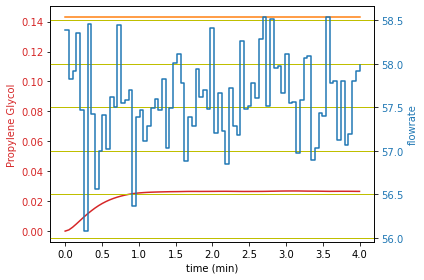

2


C:\Users\Nikita\AppData\Local\Temp/ipykernel_8856/3246592323.py:55: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  batch_acts.append(torch.tensor(action))


0.22511880821066924


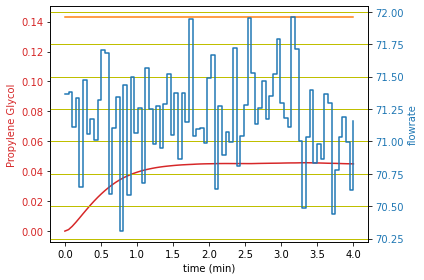

3


C:\Users\Nikita\AppData\Local\Temp/ipykernel_8856/3246592323.py:55: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  batch_acts.append(torch.tensor(action))


0.0384862328163151


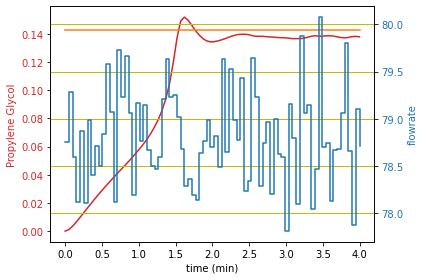

4


C:\Users\Nikita\AppData\Local\Temp/ipykernel_8856/3246592323.py:55: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  batch_acts.append(torch.tensor(action))


0.030990269376046334


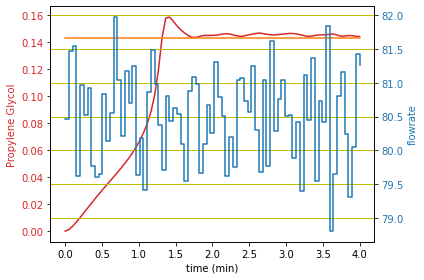

5


C:\Users\Nikita\AppData\Local\Temp/ipykernel_8856/3246592323.py:55: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  batch_acts.append(torch.tensor(action))


0.03079593991954732


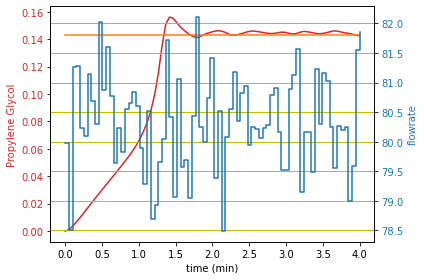

6


C:\Users\Nikita\AppData\Local\Temp/ipykernel_8856/3246592323.py:55: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  batch_acts.append(torch.tensor(action))


0.030213984812381505


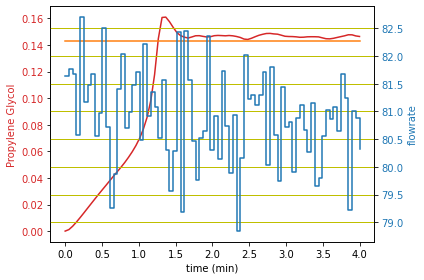

7


C:\Users\Nikita\AppData\Local\Temp/ipykernel_8856/3246592323.py:55: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  batch_acts.append(torch.tensor(action))


0.030027339068010535


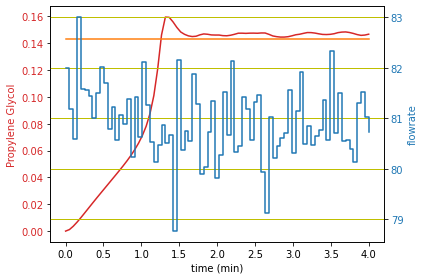

8


C:\Users\Nikita\AppData\Local\Temp/ipykernel_8856/3246592323.py:55: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  batch_acts.append(torch.tensor(action))


0.030105010777159727


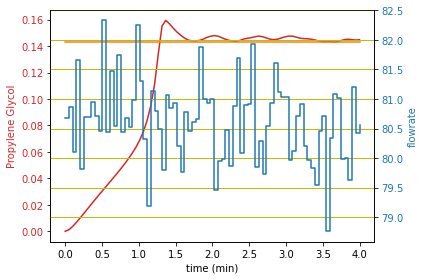

9


C:\Users\Nikita\AppData\Local\Temp/ipykernel_8856/3246592323.py:55: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  batch_acts.append(torch.tensor(action))


0.03047265754681126


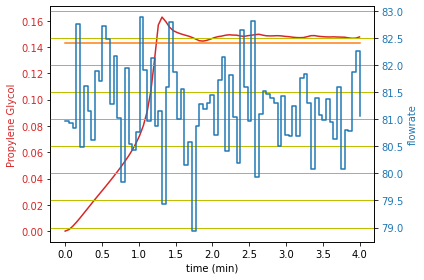

10


C:\Users\Nikita\AppData\Local\Temp/ipykernel_8856/3246592323.py:55: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  batch_acts.append(torch.tensor(action))


0.03141784008134171


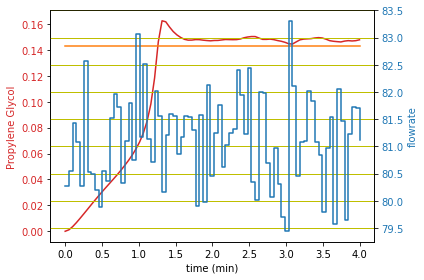

11


C:\Users\Nikita\AppData\Local\Temp/ipykernel_8856/3246592323.py:55: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  batch_acts.append(torch.tensor(action))


0.03183619702719222


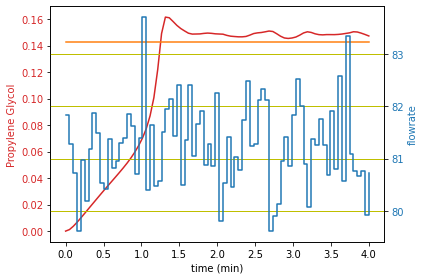

12


C:\Users\Nikita\AppData\Local\Temp/ipykernel_8856/3246592323.py:55: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  batch_acts.append(torch.tensor(action))


0.03367901834718628


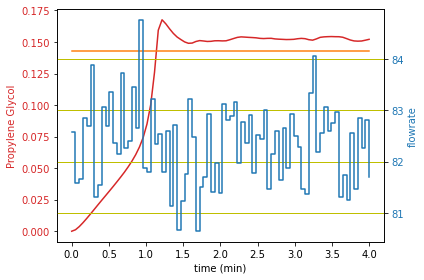

13


C:\Users\Nikita\AppData\Local\Temp/ipykernel_8856/3246592323.py:55: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  batch_acts.append(torch.tensor(action))


0.03266548573795713


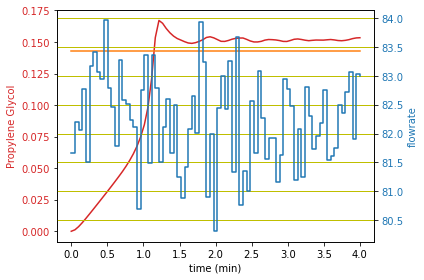

14


C:\Users\Nikita\AppData\Local\Temp/ipykernel_8856/3246592323.py:55: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  batch_acts.append(torch.tensor(action))


0.03245373057814164


KeyboardInterrupt: 

In [10]:
# seed = 100
seed = 50
random.seed(seed)
torch.manual_seed(seed)
np.random.seed(seed)

t_so_far = 0 
i_so_far = 0 
clip = 0.2
LOSS = []
CSTR_PPO = []
rewards = []
avg_rewards = []

episode_reward = []
def average(lst):
    return sum(lst) / len(lst)
returns = []
total_timesteps = 1000000
y=0
while t_so_far < total_timesteps:     
    y = y+1
    print(y)                                                            
    batch_obs = []
    propylene_glycol = []
    batch_acts = []
    batch_log_probs = []
    batch_rews = []
    batch_rtgs = []
    flowrate = []
    #batch_lens = []
    ep_rews = []
    t = 0.01
    lo = 0
    while t < 4 :
        ep_rews = [] 
        obs = [0, 3.45, 0, 0, 75]
        ep_t = 0
        while ep_t < 80:
            ep_t = ep_t + 1
            batch_obs.append(obs)
            propylene_glycol.append(obs[2])
            dist = model1(torch.FloatTensor(obs))
            action = dist.sample()
            action = abs(action)
            B=action.numpy()
            flowrate.append(B)
            log_prob = dist.log_prob(action)
            new_obs, rew = CSTR(B, t, obs)
            
            lo+=(np.abs(new_obs[2]-0.143)**2)*(t)**2
            
            obs=new_obs
            ep_rews.append(rew)
            batch_acts.append(torch.tensor(action))
            batch_log_probs.append(log_prob)
            t = t + 0.05
        batch_rews.append(ep_rews)
    batch_obs = torch.tensor(batch_obs, dtype=torch.float)
    batch_acts = torch.tensor(batch_acts, dtype=torch.float)
    batch_log_probs = torch.tensor(batch_log_probs, dtype=torch.float)
    batch_rtgs = compute_rtgs(batch_rews)  
    dt = 0.05
    T = 4
    lo = math.sqrt(lo/80)
    print(lo)
    plot_G(propylene_glycol,flowrate)
    V, _ = Evaluate(batch_obs, batch_acts)
    A_k = batch_rtgs - torch.squeeze(V.T,0).detach()  
    A_k = (A_k - A_k.mean()) / (A_k.std() + 1e-10)
    PPO(ppo_epochs, batch_obs, batch_acts, batch_log_probs, A_k, batch_rtgs)
    
    CSTR_PPO.append(propylene_glycol)
    
    
    rewards.append(rew)
#     avg_rewards.append(np.mean(rewards[-10:]))
    
    np.savetxt("C:\\Users\\Nikita\\Objective 3\\CSTR_PPO.csv",CSTR_PPO,delimiter=",")

In [11]:
torch.save(model1.state_dict(), 'pretrain_PPO.pt')

In [ ]:
avg_rewards = np.mean(rewards[-10:])

In [ ]:
obs = [0, 3.45, 0, 0, 75]